In [66]:
import scanpy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from datetime import datetime

from auxiliar import *
from scmap import *

# Parameters

In [67]:
# dataset_name = "full"
dataset_name = "wildtype"
# dataset_name = "T_mutant"
# dataset_name = "Eomes_mutant"

# parameters_file = "parameters_full.csv"
parameters_file = "parameters_by_condition.csv"

In [68]:

# dataset_reference = "susanne"
# dataset_reference = "prisca"
dataset_reference = "pijuan"

parameters = pd.read_csv(parameters_file, index_col=0).loc[dataset_name, :].to_dict()
print("Parameters: ")
parameters

Parameters: 


{'n_top_genes': 2000,
 'n_top_genes.1': 2000,
 'n_pcs': 30,
 'n_neighbors': 15,
 'cell_cycle_regression': True,
 'resolutions': '[0.1,0.2,0.5,1]'}

In [69]:
file_name = f"adata_{dataset_name}.h5ad"

# Load data

In [70]:
adata = scp.read(f"data_processed/{file_name}")
adata.layers["counts_log1p"] = np.log1p(adata.layers["counts"])

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [71]:
if dataset_reference == "susanne":
    adata_reference = scp.read("data_other_studies/susanne/adata.h5ad")

    m = scp.read_mtx("data_other_studies/susanne/matrix.mtx").T

    gs = pd.read_csv("data_other_studies/susanne/genes.tsv",sep="\t",header=None)[0].values
    genes = set(adata_reference.var["gene_ids"].values)
    keep_genes = [g in genes for g in gs]

    cs = pd.read_csv("data_other_studies/susanne/barcodes.tsv",sep="\t",header=None).values[:,0]
    cells = set(adata_reference.obs.index)
    keep_cells = [i in cells for i in cs]    

    adata_reference.layers["counts"] = m[keep_cells, keep_genes].X
    adata_reference.layers["counts_log1p"] = np.log1p(adata_reference.layers["counts"])
    adata_reference.obs["annotation"] = adata_reference.obs["leiden"].values
    
elif dataset_reference == "prisca":

    adata_reference = scp.read("data_other_studies/prisca/adata.h5ad")
    adata_reference.layers["counts_log1p"] = np.log1p(adata_reference.layers["counts"])
    adata_reference.obs["annotation"] = adata_reference.obs["celltypeannotation"].values

    scp.pp.log1p(adata_reference)
    scp.pp.highly_variable_genes(adata_reference, n_top_genes=2000, flavor="seurat", subset=True)

elif dataset_reference == "pijuan":

    adata_reference = scp.read("data_other_studies/pijuan/adata.h5ad")
    adata_reference.layers["counts"] = adata_reference.X.copy()
    adata_reference.layers["counts_log1p"] = np.log1p(adata_reference.layers["counts"])
    adata_reference.obs["annotation"] = adata_reference.obs["celltype"].values
    adata_reference.obsm["X_umap"] = adata_reference.obs[["umapX","umapY"]].values
    adata_reference.var_names = pd.read_csv("data_other_studies/pijuan/genes.tsv", sep="\t", header=None)[0].values

    scp.pp.log1p(adata_reference)
    scp.pp.highly_variable_genes(adata_reference, n_top_genes=2000, flavor="seurat", subset=True)

    adata_reference = adata_reference[adata_reference.obs["umapX"].notna(),:]

    adata.var_names = list(map(lambda x: x.split(".")[0], adata.var["gene_id"].values))

else:

    raise ValueError("Dataset reference not available")

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Annotate and project Project

In [72]:
scmap_annotate(adata, adata_reference, "annotation", algorithm_flavor="cell", knn=5, key_layer="counts_log1p", similarity_threshold=.5)
scmap_projection(adata, adata_reference, "X_umap", knn=1)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/2659505059.py:15: UserWarning: The palette list has more values (89) than needed (38), which may not be intended.
  sns.scatterplot(x = X_ref[:, 0], y = X_ref[:, 1], s=20, hue = hue_ref, hue_order=order, palette=palette, ax=ax[0])
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/2659505059.py:19: UserWarning: The palette list has more values (89) than needed (38), which may not be intended.
  sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = hue, hue_order=order, s=40, palette = palette, ax=ax[1])
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/2659505059.py:25: UserWarning: The palette list has more values (89) than needed (15), which may not be intended.
  sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = hue, s=40, palette = palette, ax=ax[2])


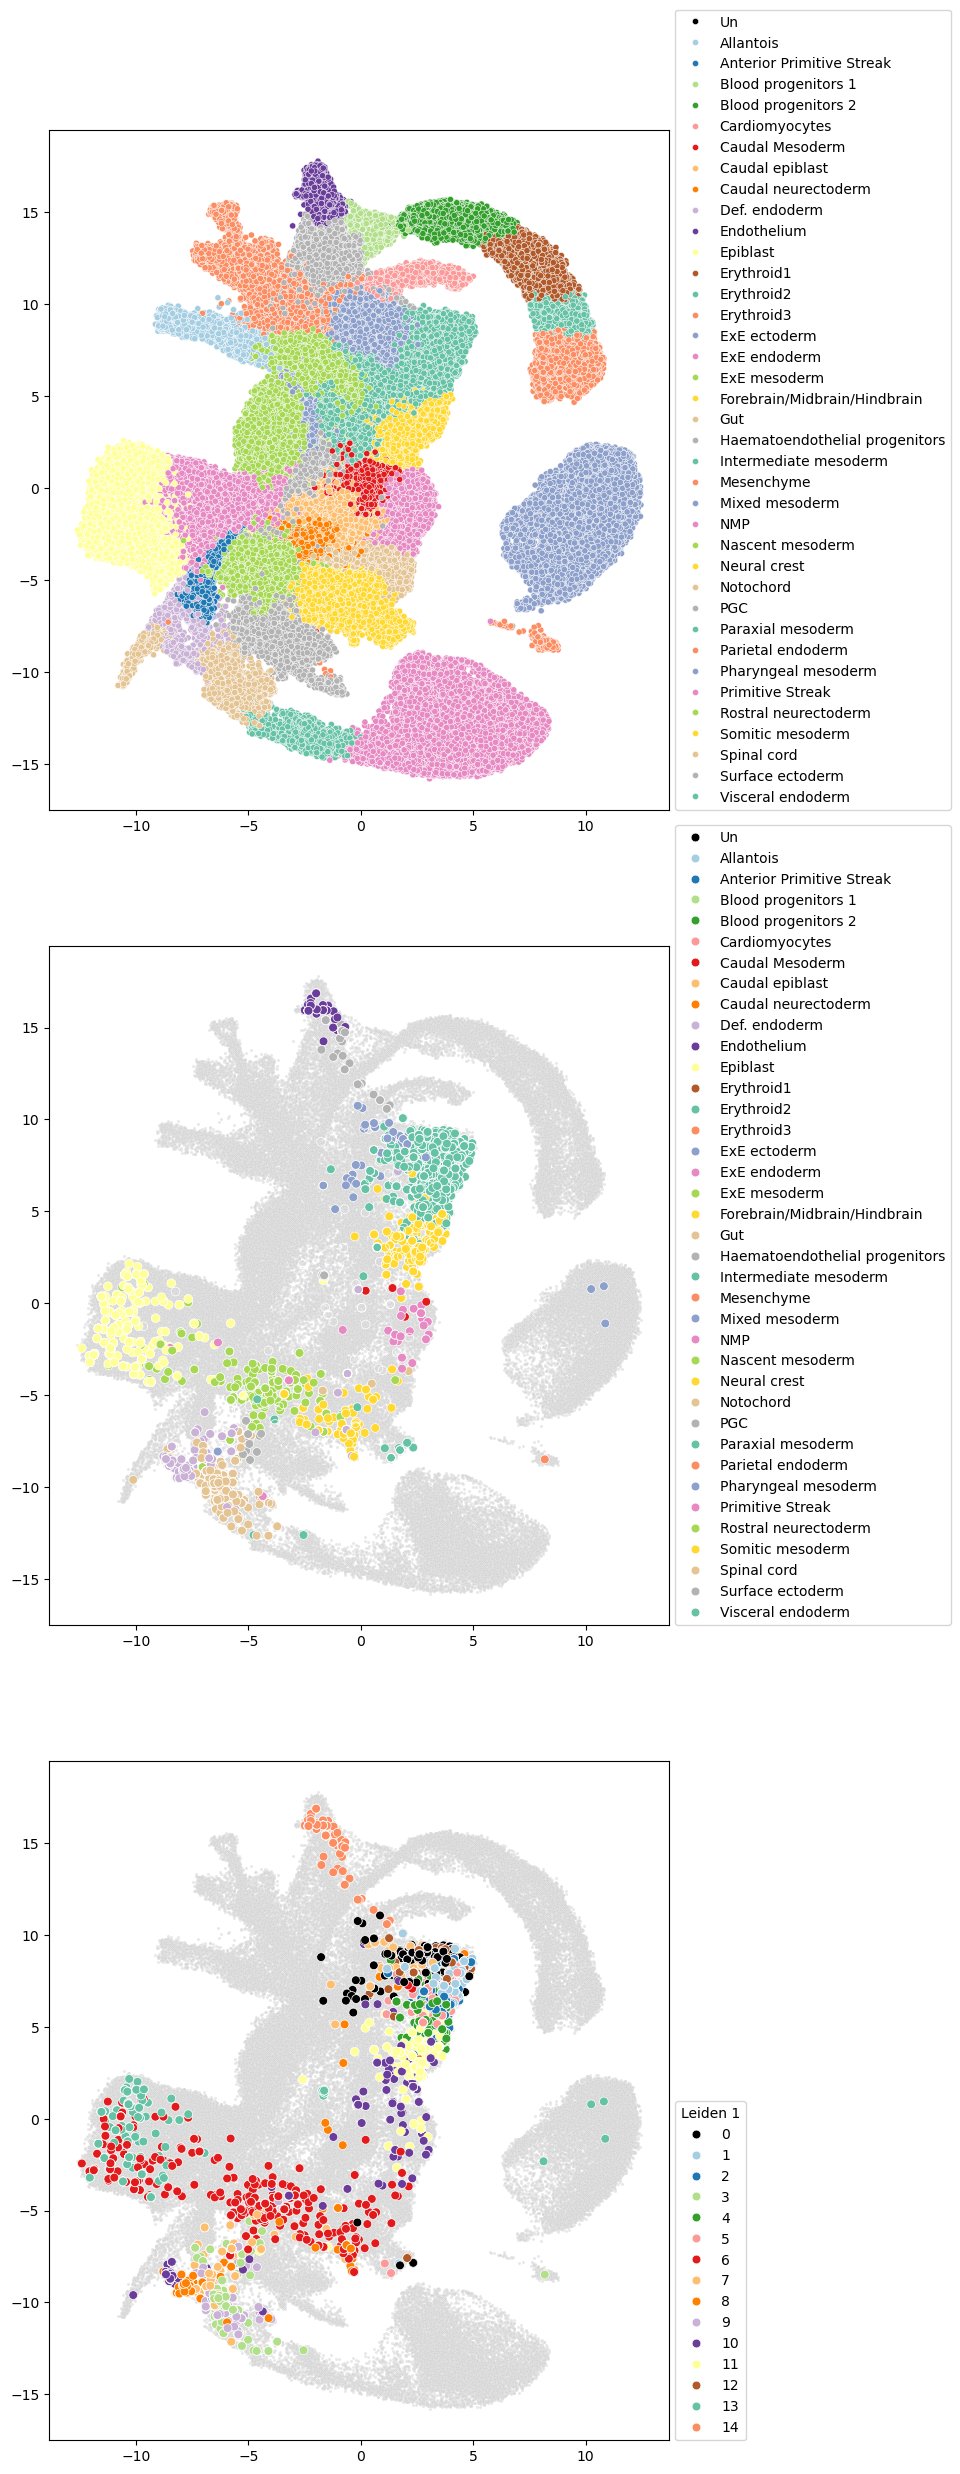

In [73]:
X_ref = adata_reference.obsm["X_umap"]
hue_ref = adata_reference.obs["annotation"].values

X = adata.obsm["X_scmap_projection"]
hue = adata.obs["scmap_annotation"]

if isinstance(hue_ref[0], str):
    order = ["Un"] + [str(i) for i in np.sort(hue_ref.unique())]
else:
    order = ["Un"] + [str(i) for i in range(0, len(hue_ref.unique()))]
palette = ["black"]+sns.color_palette("Paired")+sns.color_palette("Set2", len(order))+sns.color_palette("Set1", len(order))

fig, ax = plt.subplots(3,1,figsize=(8, 30))

sns.scatterplot(x = X_ref[:, 0], y = X_ref[:, 1], s=20, hue = hue_ref, hue_order=order, palette=palette, ax=ax[0])
ax[0].legend(loc=(1.01,0))

sns.scatterplot(x = X_ref[:, 0], y = X_ref[:, 1], color = "lightgray", s=5, alpha = 0.5, ax=ax[1])
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = hue, hue_order=order, s=40, palette = palette, ax=ax[1])
ax[1].legend(loc=(1.01,0))

hue = adata.obs["leiden_1"]

sns.scatterplot(x = X_ref[:, 0], y = X_ref[:, 1], color = "lightgray", s=5, alpha = 0.5, ax=ax[2])
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = hue, s=40, palette = palette, ax=ax[2])
ax[2].legend(loc=(1.01,0), title="Leiden 1")

fig.savefig(f"figures/full/scmap_projection_{dataset_reference}.png", bbox_inches='tight', transparent=True)

# Robustness annotation over parameters

In [74]:
count = 0
l = []
for flavor in ["cell"]:
    for similarity_threshold in [0.5, 0.7]:
        for knn in [1, 3, 5]:
            labels = scmap_annotate(adata, adata_reference, "annotation", key_layer="counts_log1p", knn=knn, algorithm_flavor=flavor, similarity_threshold=similarity_threshold, inplace=False)
            adata.obs[f"annotation_{count}"] = labels
            l.append(f"annotation_{count}")
            count += 1

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gatocor/m

In [75]:
v = adata.obs[l].mode(axis=1).values[:,0]
p = (adata.obs[l].values == v.reshape(-1,1)).sum(axis=1) / len(l)

In [76]:
adata.obs["annotation_mode"] = v
adata.obs["annotation_mode_probability"] = p

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/3779829617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 1
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/3779829617.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


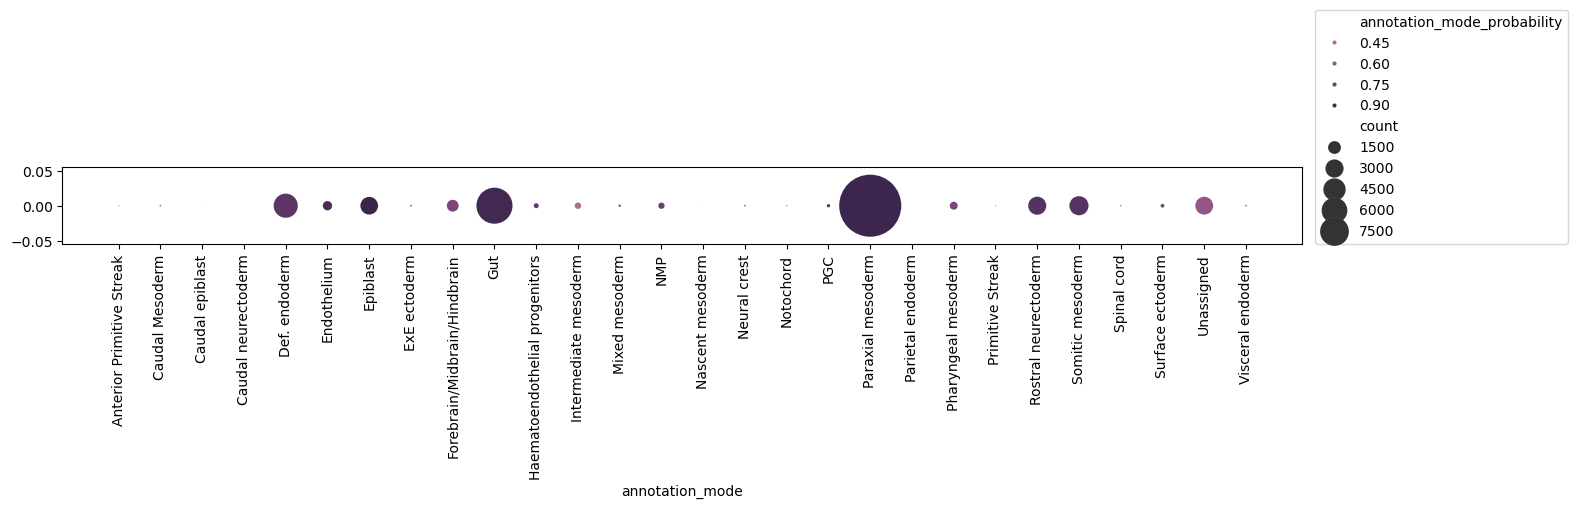

In [77]:
df = adata.obs[["annotation_mode", "annotation_mode_probability"]]
df["count"] = 1
table = df.groupby(["annotation_mode"]).agg({"count":"sum", "annotation_mode_probability":"mean"}).reset_index()

fig, ax = plt.subplots(1,1,figsize=(16, 1))

sns.scatterplot(data = table, x = "annotation_mode", y=0, hue="annotation_mode_probability", size="count", ax=ax, hue_norm=(0,1), sizes=(0,2000))
ax.legend(loc=(1.01,0), markerscale=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.savefig(f"figures/{dataset_name}/scmap_annotation_{dataset_reference}.png", bbox_inches='tight', transparent=True)

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/3083919861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 1
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/3083919861.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(["annotation_mode", resolution]).agg({"count":"sum", "annotation_mode_probability":"mean"}).reset_index()
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_78871/3083919861.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

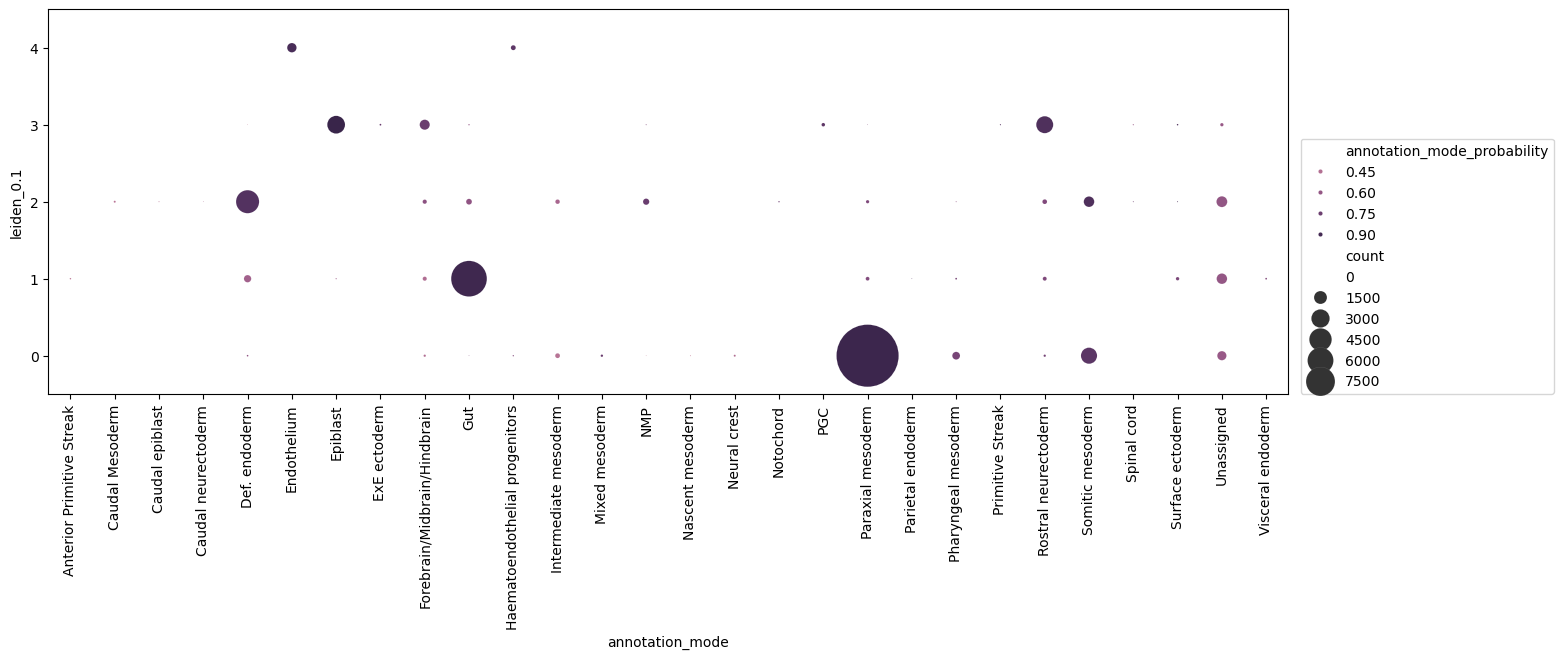

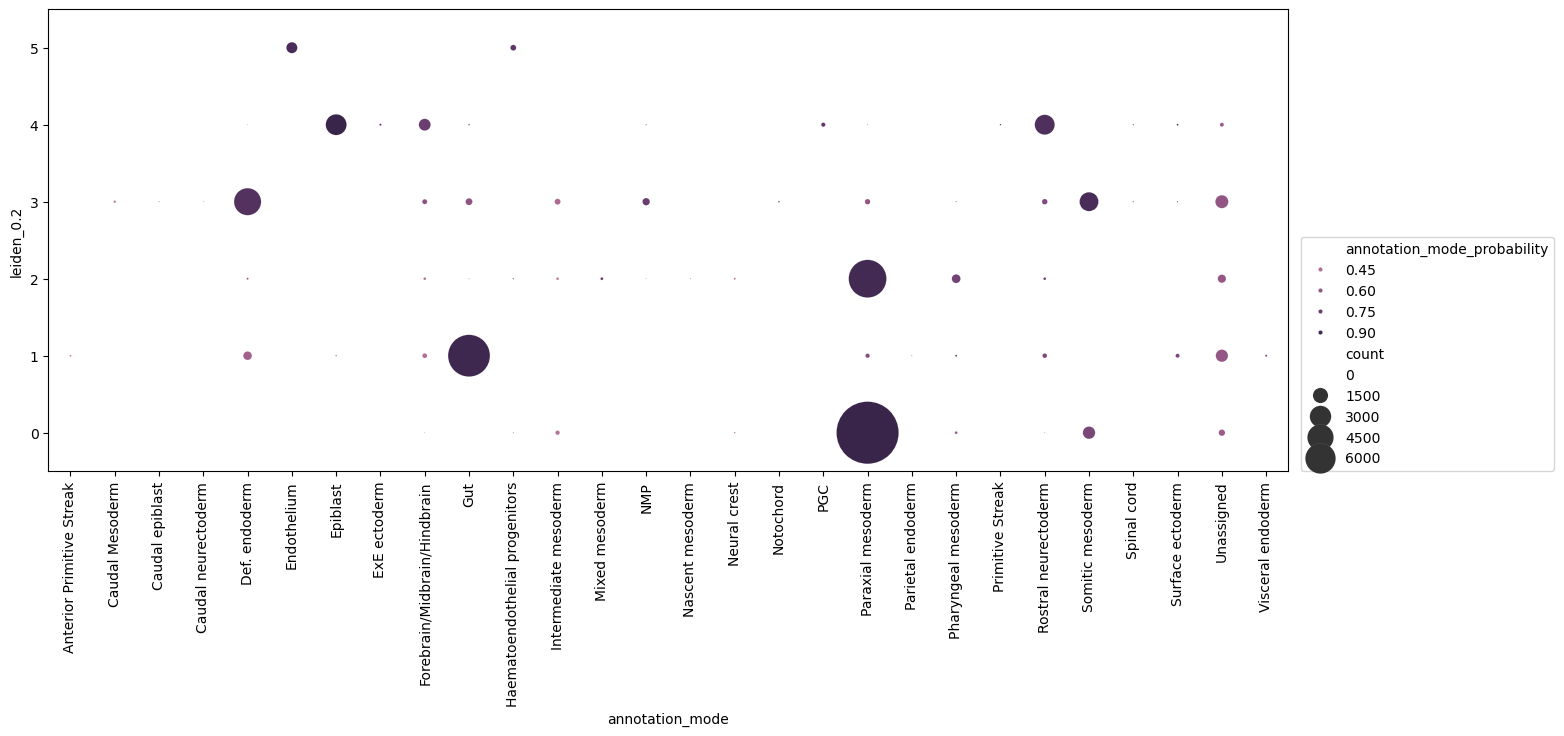

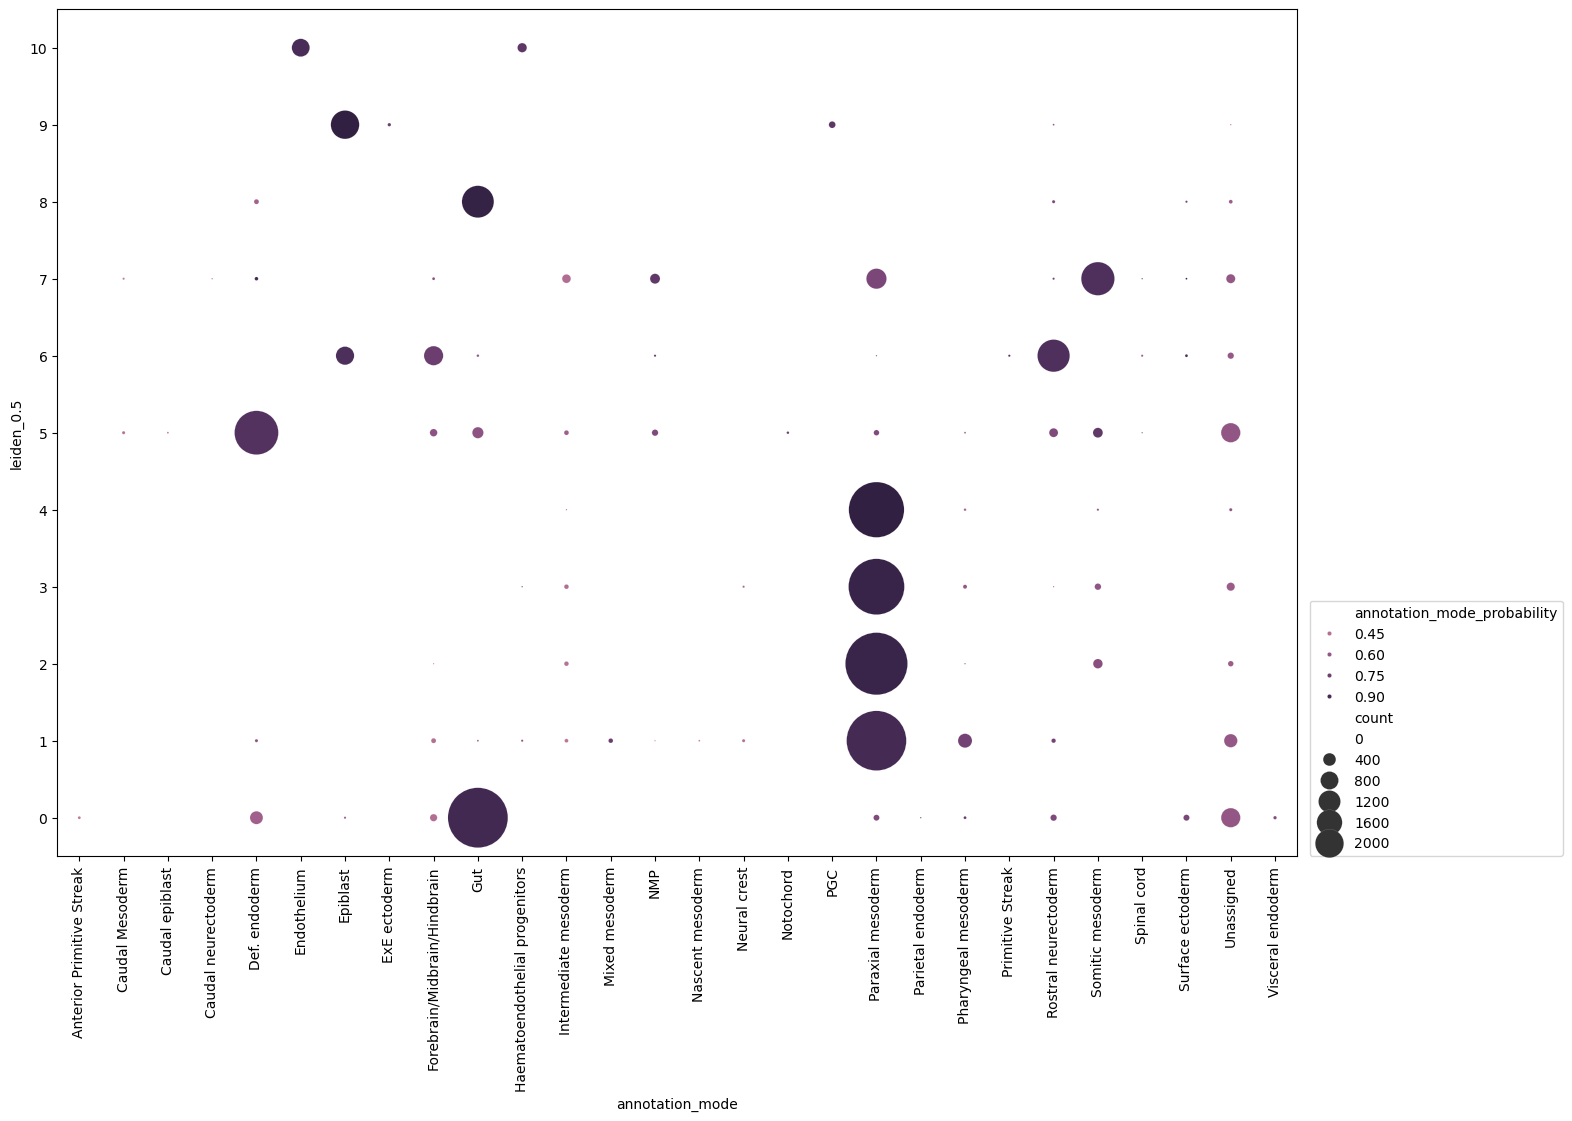

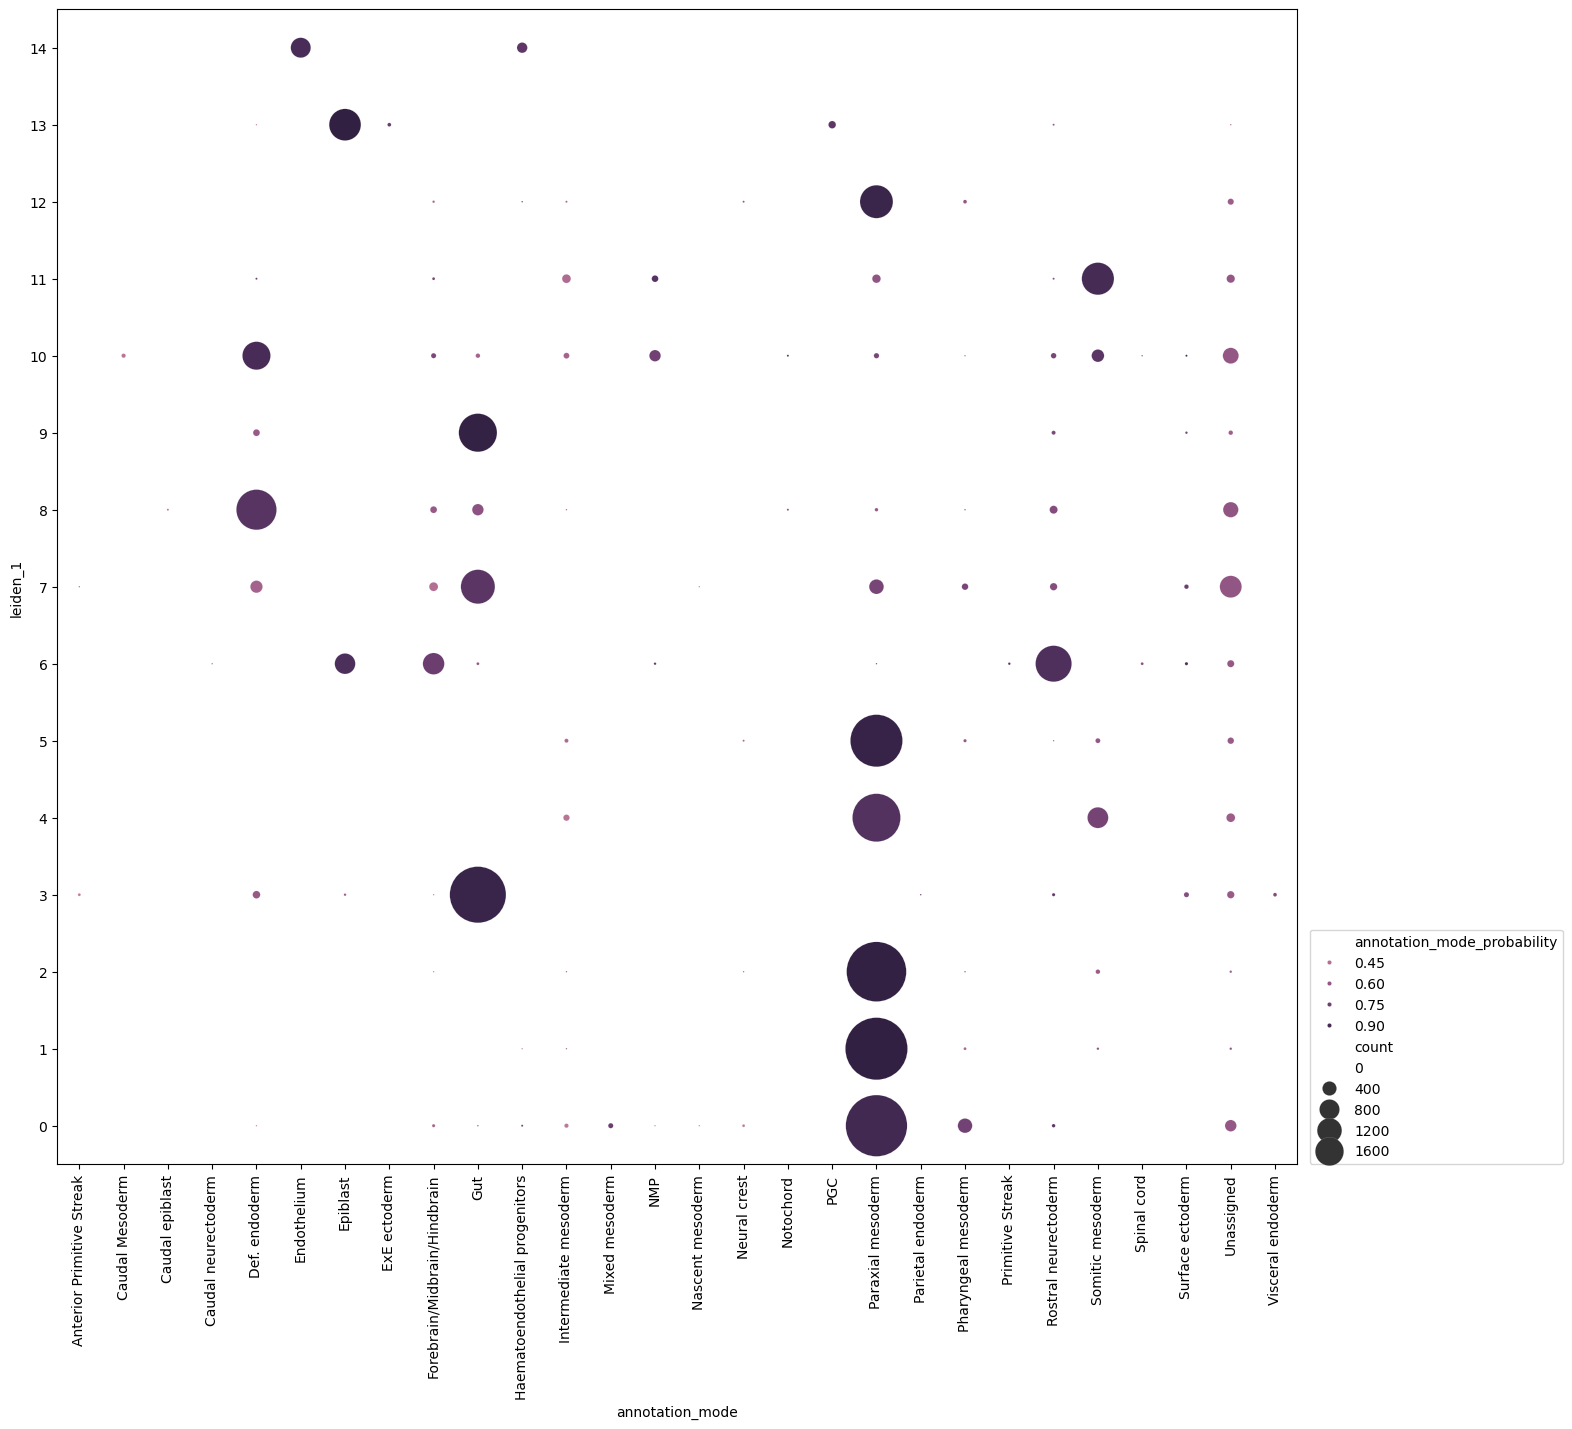

In [78]:
for res in eval(parameters["resolutions"]):
    resolution = f"leiden_{res}"
    df = adata.obs[["annotation_mode", "annotation_mode_probability", resolution]]
    df["count"] = 1
    table = df.groupby(["annotation_mode", resolution]).agg({"count":"sum", "annotation_mode_probability":"mean"}).reset_index()

    n_clusters = len(table[resolution].unique())
    fig, ax = plt.subplots(1,1,figsize=(16, n_clusters))

    sns.scatterplot(data = table, x = "annotation_mode", y=resolution, hue="annotation_mode_probability", size="count", ax=ax, sizes=(0,2000), hue_norm=(0,1))
    ax.legend(loc=(1.01,0), markerscale=0.5)
    ax.set_xlim(-0.5, len(table["annotation_mode"].unique())-0.5)
    ax.set_ylim(-0.5, n_clusters-0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


    fig.savefig(f"figures/{dataset_name}/scmap_annotation_{dataset_reference}_{resolution}.png", bbox_inches='tight', transparent=True)

In [79]:
if file_name == "full":
    for res in eval(parameters["resolutions"]):
        resolution = f"leiden_{res}"
        df = adata.obs[["annotation_mode", "annotation_mode_probability", resolution, "condition"]]
        df["resolution_condition"] = df[resolution].astype(str) + "_" + df["condition"].astype(str)
        df["count"] = 1
        table = df.groupby(["annotation_mode", "resolution_condition"]).agg({"count":"sum", "annotation_mode_probability":"mean"}).reset_index()

        n_clusters = len(table["resolution_condition"].unique())
        fig, ax = plt.subplots(1,1,figsize=(16, n_clusters))

        sns.scatterplot(data = table, x = "annotation_mode", y="resolution_condition", hue="annotation_mode_probability", size="count", ax=ax, sizes=(0,2000), hue_norm=(0,1))
        ax.legend(loc=(1.01,0), markerscale=0.5)
        ax.set_xlim(-0.5, len(table["annotation_mode"].unique())-0.5)
        ax.set_ylim(-0.5, n_clusters-0.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        fig.savefig(f"figures/{dataset_name}/scmap_annotation_{dataset_reference}_{resolution}_condition.png", bbox_inches='tight', transparent=True)

# Comparison of gene expression

In [80]:
genes = [str(i) for i in pd.read_csv("gene_list.csv", header=None).values[:,0].tolist() if i in adata.var_names and i in adata_reference.var_names]
genes

[]

In [81]:
adata_reference[:, genes]

View of AnnData object with n_obs × n_vars = 116312 × 0
    obs: 'cell', 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'annotation'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'counts_log1p'

In [82]:
X_genes = adata[:, genes].layers["counts_log1p"].toarray()
X_genes_reference = adata_reference[:, genes].layers["counts_log1p"].toarray()

# X_genes /= X_genes.mean(axis=0).max()
annotation = adata.obs["annotation_mode"].values
df = pd.DataFrame(X_genes, columns=genes, index=adata.obs_names)
df["annotation"] = annotation
df["type"] = dataset_name
# X_genes_reference /= X_genes_reference.mean(axis=0).max()
annotation_reference = adata_reference.obs["annotation"].values
df_reference = pd.DataFrame(X_genes_reference, columns=genes, index=adata_reference.obs_names)
df_reference["annotation"] = annotation_reference
df_reference["type"] = dataset_reference

df_join = pd.concat([df, df_reference], axis=0)

# Melt into long format
df_long = pd.melt(
    df_join,
    id_vars=["annotation", "type"],
    value_vars=genes,
    var_name="gene",
    value_name="expression"
)

# Plot
g = sns.catplot(
    data=df_long,
    x="expression",
    hue="type",
    row="gene",
    kind="violin",
    split=True,
    height=2,
    aspect=2,
    sharex=False,
    sharey=False
)

plt.tight_layout()
plt.savefig(f"figures/{dataset_name}/violinplot_genes_{dataset_reference}.png", bbox_inches='tight', transparent=True)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 400x0 with 0 Axes>

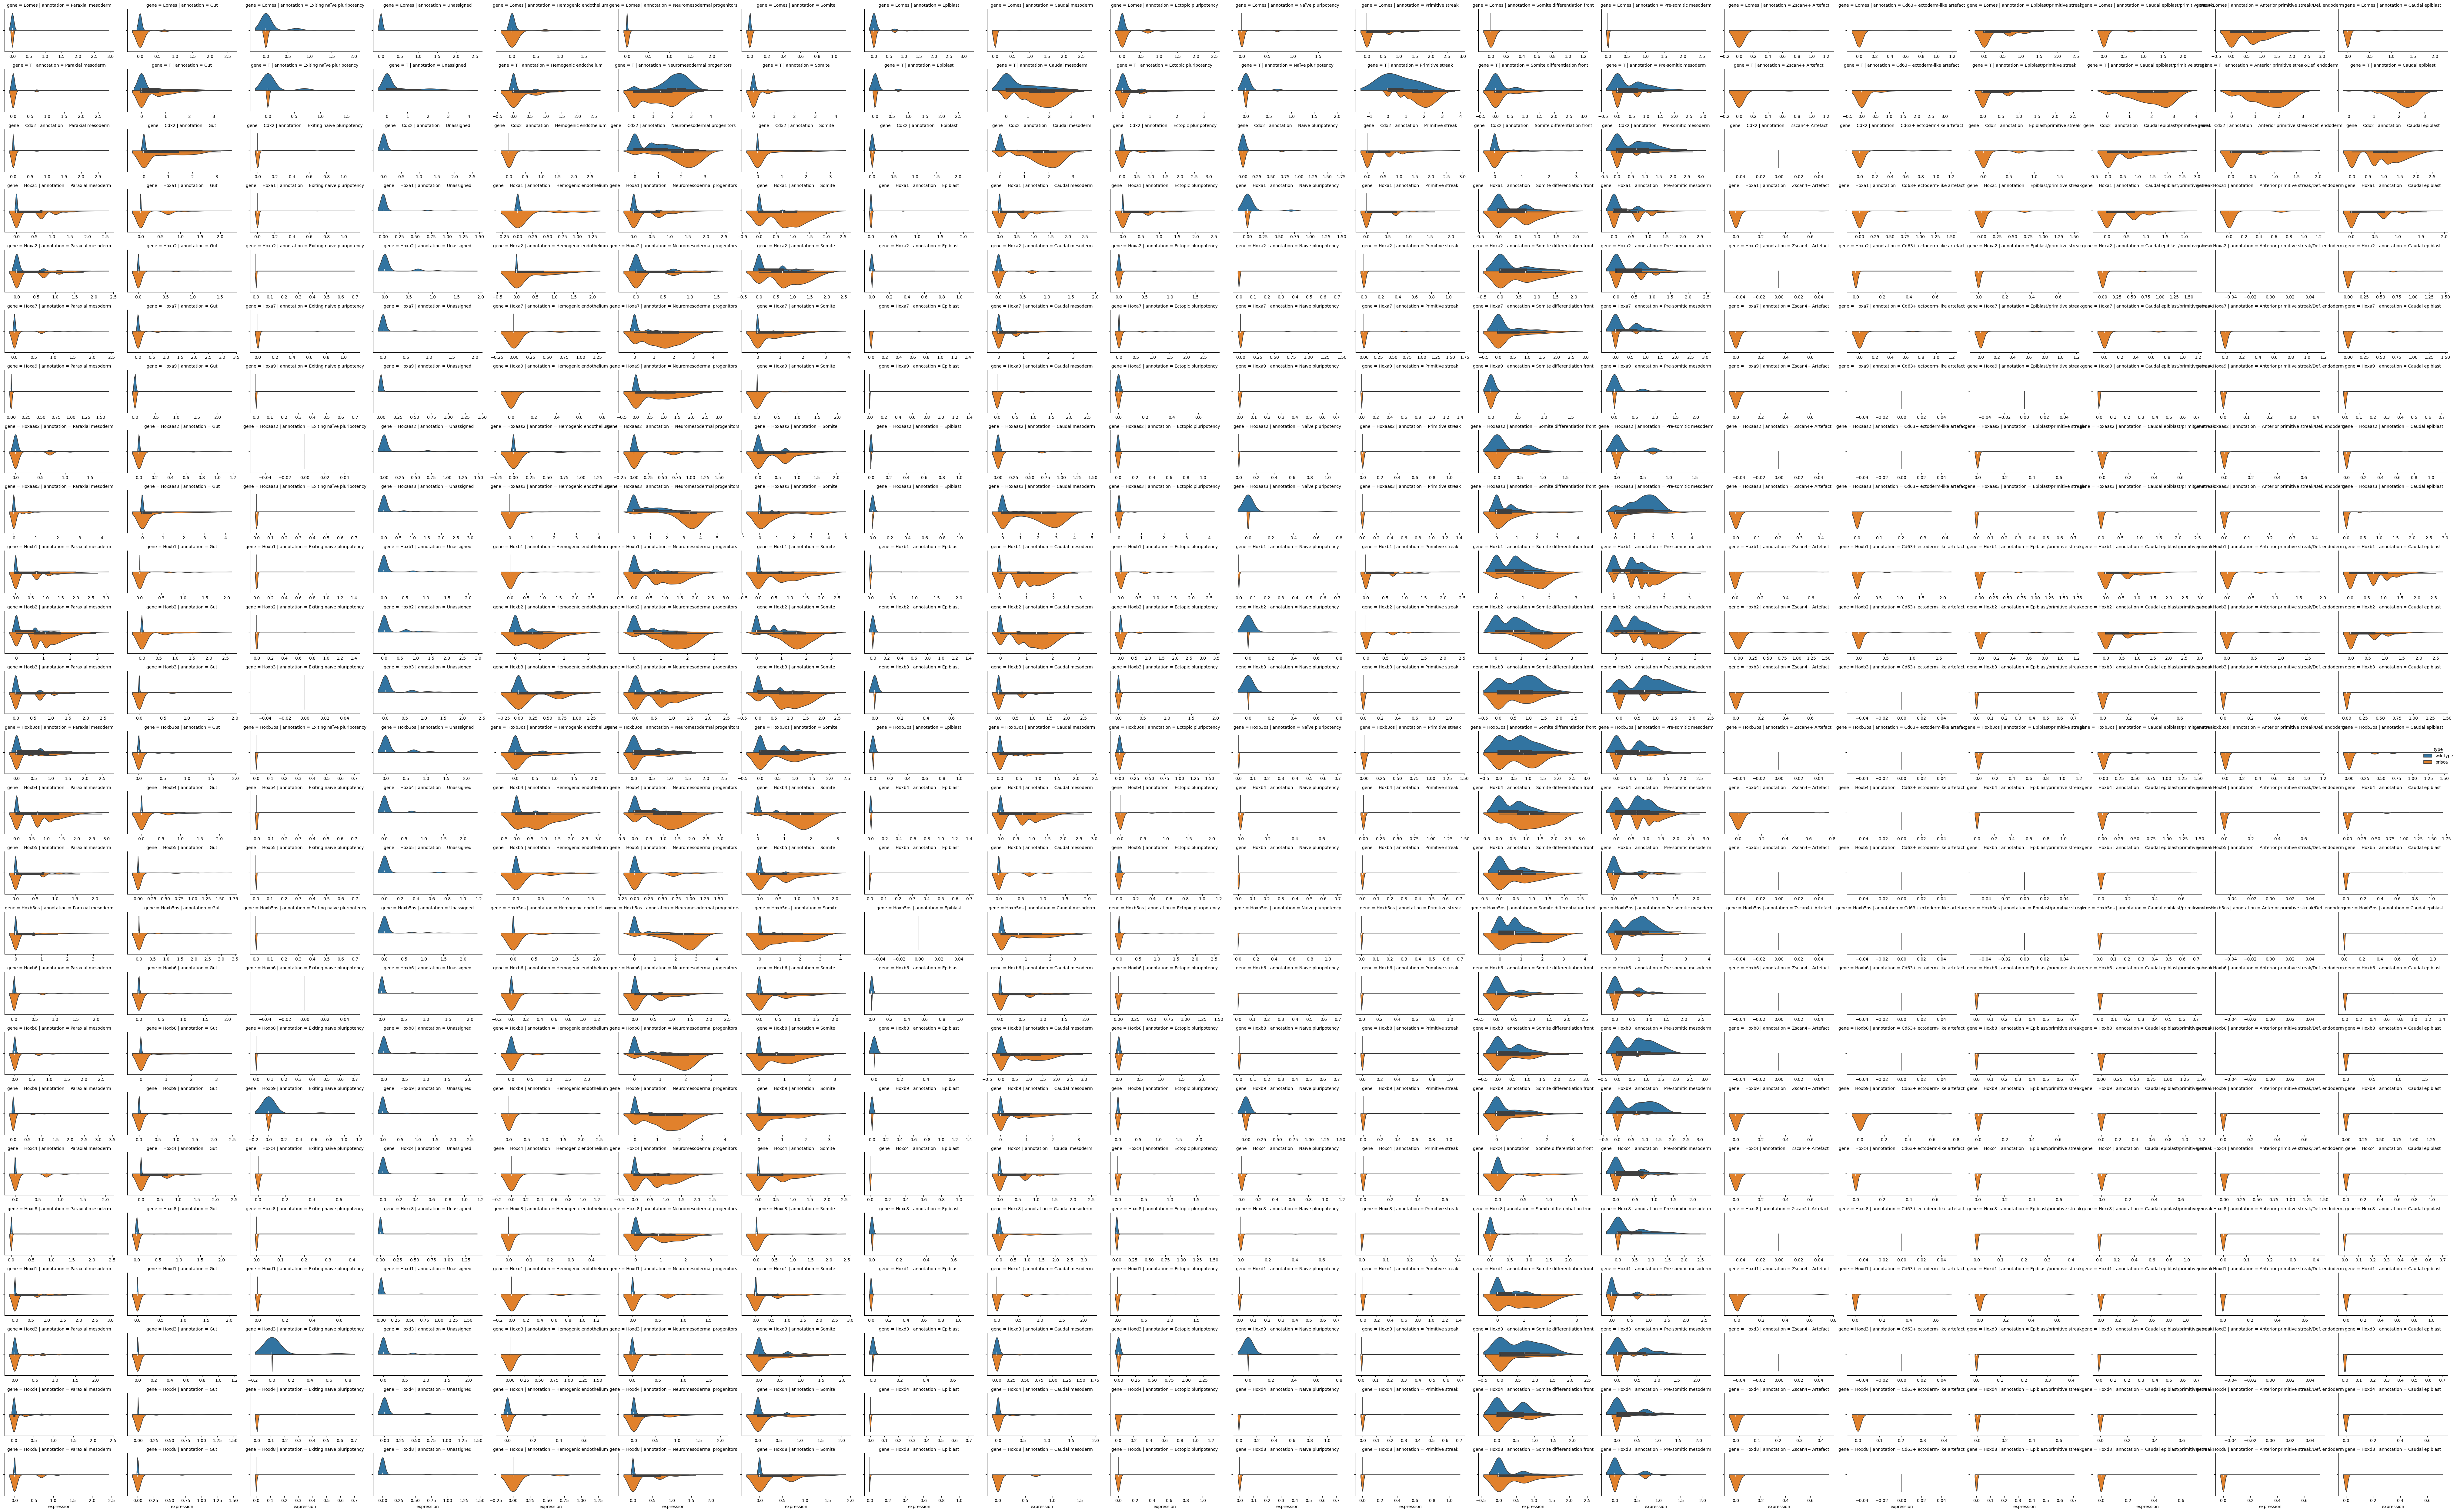

In [ ]:
X_genes = adata[:, genes].layers["counts_log1p"].toarray()
X_genes_reference = adata_reference[:, genes].layers["counts_log1p"].toarray()

# X_genes /= X_genes.mean(axis=0).max()
annotation = adata.obs["annotation_mode"].values
df = pd.DataFrame(X_genes, columns=genes, index=adata.obs_names)
df["annotation"] = annotation
df["type"] = dataset_name
# X_genes_reference /= X_genes_reference.mean(axis=0).max()
annotation_reference = adata_reference.obs["annotation"].values
df_reference = pd.DataFrame(X_genes_reference, columns=genes, index=adata_reference.obs_names)
df_reference["annotation"] = annotation_reference
df_reference["type"] = dataset_reference

df_join = pd.concat([df, df_reference], axis=0)

# Melt into long format
df_long = pd.melt(
    df_join,
    id_vars=["annotation", "type"],
    value_vars=genes,
    var_name="gene",
    value_name="expression"
)

# Plot
g = sns.catplot(
    data=df_long,
    x="expression",
    col="annotation",
    hue="type",
    row="gene",
    kind="violin",
    split=True,
    height=2,
    aspect=2,
    sharex=False,
    sharey=False
)

plt.tight_layout()
plt.savefig(f"figures/{dataset_name}/violinplot_genes_{dataset_reference}_annotation.png", bbox_inches='tight', transparent=True)

## Save analysis script

In [83]:
# Get the current date
current_date = datetime.now().strftime("%Y%m%d")

# Construct the output file name with the current date
input_file = f"analysis_projection.ipynb"
output_file = f"script_versions/analysis_projection_{current_date}"

# Convert the notebook to HTML with the new file name
!jupyter nbconvert --to html "$input_file" --output "$output_file"

[NbConvertApp] Converting notebook analysis_projection.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 6197012 bytes to script_versions/analysis_projection_20250603.html
